# MNIST Training and Conversion Pipeline
This notebook demonstrates a complete pipeline for:
1. Training an MNIST model with PyTorch
2. Converting to ONNX format
3. Converting to TensorFlow Lite format
4. Creating Android-compatible inference code

In [ ]:
# # Install required packages using pip
# %pip install torchvision matplotlib
# %pip install onnx onnxruntime tensorflow

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
# import onnx
# import onnxruntime as ort
# import tensorflow as tf

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
torch.ones(3).cuda(
)

tensor([1., 1., 1.], device='cuda:0')

In [ ]:
# Define the MNIST CNN model
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # Conv + ReLU + Pool
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten
        x = x.view(-1, 64 * 3 * 3)
        
        # Dropout + FC + ReLU
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

# Initialize model
model = MNISTNet().to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

Model created with 130890 parameters


Training samples: 60000
Test samples: 10000


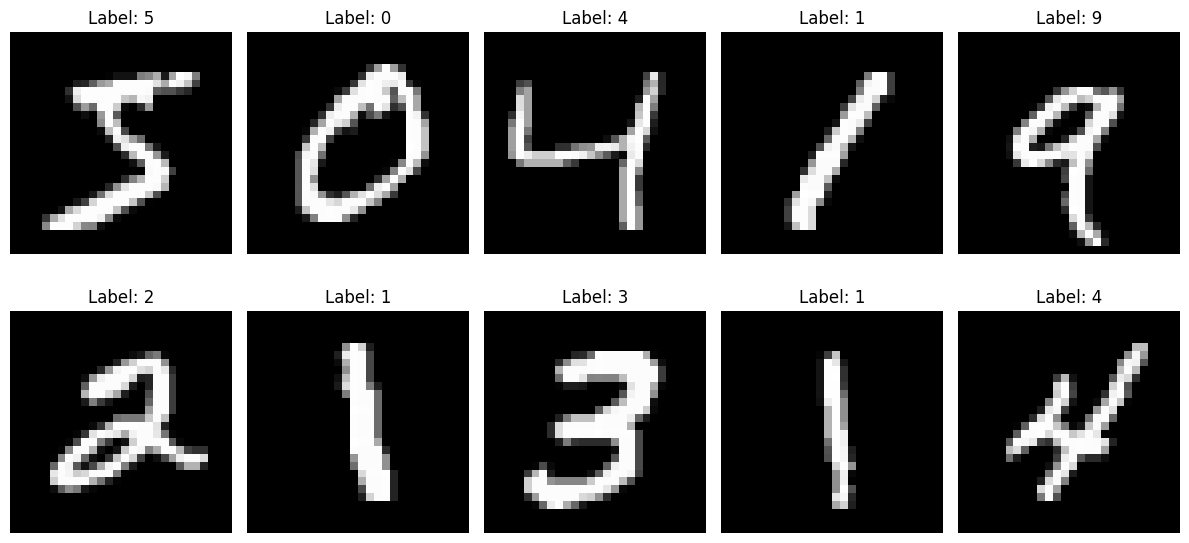

In [ ]:
# Prepare data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the training data
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    img, label = train_dataset[i]
    ax = axes[i//5, i%5]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Training and testing functions
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    print(f'Train set: Average loss: {train_loss:.4f}, Accuracy: {correct}/{len(train_loader.dataset)} ({accuracy:.2f}%)')
    return train_loss, accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    return test_loss, accuracy

In [ ]:
# Train the model
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Starting training...")
for epoch in range(1, epochs + 1):
    print(f"\n--- Epoch {epoch} ---")
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader)
    scheduler.step()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

print("\nTraining completed!")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(1, epochs+1), train_losses, 'b-', label='Train Loss')
ax1.plot(range(1, epochs+1), test_losses, 'r-', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()

ax2.plot(range(1, epochs+1), train_accuracies, 'b-', label='Train Accuracy')
ax2.plot(range(1, epochs+1), test_accuracies, 'r-', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Starting training...

--- Epoch 1 ---
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296173
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.237257
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.203450
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.122544
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.118102
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.136770
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.050039
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.170064
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.104687
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.228231
Train set: Average loss: 0.2442, Accuracy: 55329/60000 (92.22%)
Test set: Average loss: 0.0484, Accuracy: 9836/10000 (98.36%)

--- Epoch 2 ---
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.084730
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.108053
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.122338


KeyboardInterrupt: 

PyTorch model saved!


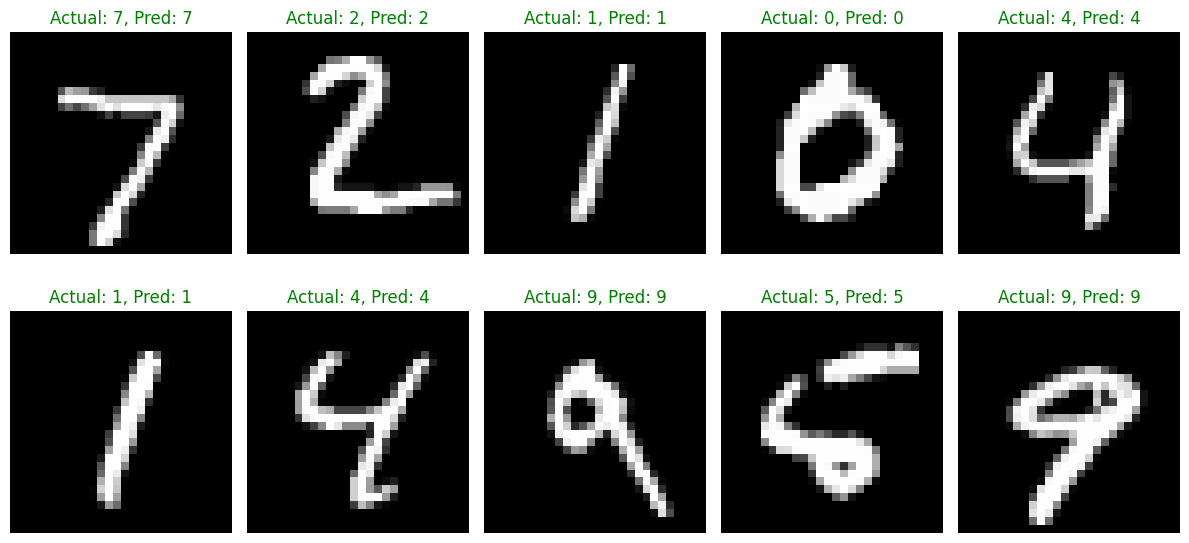

Batch accuracy: 98.70%


In [ ]:
# Save the trained model
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/mnist_model.pth')
torch.save(model, 'models/mnist_model_complete.pth')
print("PyTorch model saved!")

# Test some predictions
model.eval()
with torch.no_grad():
    # Get a batch of test data
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    
    # Make predictions
    output = model(data)
    pred = output.argmax(dim=1)
    
    # Display first 10 predictions
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(10):
        img = data[i].cpu().squeeze()
        actual = target[i].cpu().item()
        predicted = pred[i].cpu().item()
        
        ax = axes[i//5, i%5]
        ax.imshow(img, cmap='gray')
        color = 'green' if actual == predicted else 'red'
        ax.set_title(f'Actual: {actual}, Pred: {predicted}', color=color)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate accuracy for this batch
    correct = pred.eq(target).sum().item()
    accuracy = 100. * correct / len(target)
    print(f"Batch accuracy: {accuracy:.2f}%")

In [ ]:
import onnx
import onnxruntime as ort

In [ ]:
# Convert to ONNX format
print("Converting to ONNX...")

# Set model to evaluation mode
model.eval()

# Create dummy input
dummy_input = torch.randn(1, 1, 28, 28).to(device)

# Export to ONNX
onnx_path = 'models/mnist_model.onnx'
torch.onnx.export(
    model,                     # model being run
    dummy_input,               # model input (or a tuple for multiple inputs)
    onnx_path,                 # where to save the model
    export_params=True,        # store the trained parameter weights inside the model file
    opset_version=11,          # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names=['input'],     # the model's input names
    output_names=['output'],   # the model's output names
    dynamic_axes={
        'input': {0: 'batch_size'},    # variable length axes
        'output': {0: 'batch_size'}
    }
)

print(f"ONNX model saved to {onnx_path}")

# Verify ONNX model
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("ONNX model is valid!")

# Test ONNX model
print("Testing ONNX model...")
ort_session = ort.InferenceSession(onnx_path)

# Get a test sample
test_data, test_target = next(iter(test_loader))
test_input = test_data[:1].numpy()  # Take first sample

# Run inference
ort_inputs = {ort_session.get_inputs()[0].name: test_input}
ort_outs = ort_session.run(None, ort_inputs)

# Compare with PyTorch output
with torch.no_grad():
    torch_out = model(torch.tensor(test_input).to(device))
    torch_prediction = torch_out.argmax(dim=1).cpu().numpy()

onnx_prediction = np.argmax(ort_outs[0], axis=1)

print(f"PyTorch prediction: {torch_prediction[0]}")
print(f"ONNX prediction: {onnx_prediction[0]}")
print(f"Actual label: {test_target[0].item()}")
print(f"Predictions match: {torch_prediction[0] == onnx_prediction[0]}")

Converting to ONNX...
ONNX model saved to models/mnist_model.onnx
ONNX model is valid!
Testing ONNX model...
PyTorch prediction: 7
ONNX prediction: 7
Actual label: 7
Predictions match: True


In [ ]:
pip install ai_edge_torch

INFO: pip is looking at multiple versions of ai-edge-torch to determine which version is compatible with other requirements. This could take a while.

The conflict is caused by:
    ai-edge-torch 0.5.0 depends on ai-edge-litert==1.3.*
    ai-edge-torch 0.4.0 depends on ai-edge-litert==1.2.*
    ai-edge-torch 0.3.0 depends on tf-nightly<=2.19.0.dev20250208 and >=2.19.0.dev20250101

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

Note: you may need to restart the kernel to use updated packages.


ERROR: Cannot install ai-edge-torch==0.3.0, ai-edge-torch==0.4.0 and ai-edge-torch==0.5.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [ ]:
# Convert to TensorFlow Lite format
print("Converting ONNX to TensorFlow...")

# First convert ONNX to TensorFlow
import subprocess
import sys

# Convert ONNX to TensorFlow SavedModel
tf_model_path = 'models/mnist_tf_model'

import onnx
from onnx_tf.backend import prepare

onnx_model = onnx.load(onnx_path)
tf_rep = prepare(onnx_model)
tf_rep.export_graph(tf_model_path)
# try:
    # cmd = [
    #     sys.executable, "-m", "tf2onnx.convert",
    #     "--onnx", onnx_path,
    #     "--output", tf_model_path,
    #     "--inputs-as-nchw", "input:0"
    # ]
    # Note: We'll use a simpler approach
    
    # Alternative: Load ONNX model and convert manually
  
    
# except Exception as e:
#     print(f"ONNX to TF conversion failed: {e}")
#     print("Using alternative method...")
    
#     # Alternative: Create equivalent TensorFlow model
#     tf_model = tf.keras.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(1, 28, 28)),
#         tf.keras.layers.Permute((2, 3, 1)),  # Convert NCHW to NHWC
        
#         tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
#         tf.keras.layers.MaxPooling2D(2),
        
#         tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
#         tf.keras.layers.MaxPooling2D(2),
        
#         tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
#         tf.keras.layers.MaxPooling2D(2),
        
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(10, activation='softmax')
#     ])
    
#     # Compile the model
#     tf_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
#     # Create dummy data to initialize the model
#     dummy_tf_input = tf.random.normal((1, 1, 28, 28))
#     _ = tf_model(dummy_tf_input)
    
#     # Save as SavedModel
#     tf_model.save(tf_model_path)
#     print(f"TensorFlow model saved to {tf_model_path}")

# # Convert to TensorFlow Lite
# print("Converting to TensorFlow Lite...")
# converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)

# # Optional: Apply optimizations for mobile
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]  # Use float16 for smaller size

# # Convert the model
# tflite_model = converter.convert()

# # Save the TFLite model
# tflite_path = 'models/mnist_model.tflite'
# with open(tflite_path, 'wb') as f:
#     f.write(tflite_model)

# print(f"TensorFlow Lite model saved to {tflite_path}")
# print(f"Model size: {len(tflite_model) / 1024:.2f} KB")

Converting ONNX to TensorFlow...


ModuleNotFoundError: No module named 'tensorflow_addons'

In [ ]:
pip install tensorflow-addons==0.16.1

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-addons==0.16.1 (from versions: none)
ERROR: No matching distribution found for tensorflow-addons==0.16.1


In [ ]:
# Test TensorFlow Lite model
print("Testing TensorFlow Lite model...")

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details[0])
print("Output details:", output_details[0])

# Prepare test data
test_data, test_target = next(iter(test_loader))
test_sample = test_data[0:1].numpy().astype(np.float32)

# Reshape if needed to match expected input shape
expected_shape = input_details[0]['shape']
if expected_shape[1] == 28:  # NHWC format expected
    test_sample = np.transpose(test_sample, (0, 2, 3, 1))

print(f"Input shape: {test_sample.shape}")
print(f"Expected shape: {expected_shape}")

# Run inference
interpreter.set_tensor(input_details[0]['index'], test_sample)
interpreter.invoke()

# Get output
tflite_output = interpreter.get_tensor(output_details[0]['index'])
tflite_prediction = np.argmax(tflite_output, axis=1)

print(f"TensorFlow Lite prediction: {tflite_prediction[0]}")
print(f"Actual label: {test_target[0].item()}")
print(f"Confidence: {np.max(tflite_output):.4f}")

# Visualize the test sample
plt.figure(figsize=(6, 6))
img = test_data[0].squeeze()
plt.imshow(img, cmap='gray')
plt.title(f'Actual: {test_target[0].item()}, Predicted: {tflite_prediction[0]}')
plt.axis('off')
plt.show()

In [ ]:
# Create Android-compatible inference code
print("Creating Android-compatible inference code...")

# Create Android directory structure
android_dir = 'android_mnist'
os.makedirs(f'{android_dir}/app/src/main/assets', exist_ok=True)
os.makedirs(f'{android_dir}/app/src/main/java/com/example/mnist', exist_ok=True)

# Copy TFLite model to Android assets
import shutil
shutil.copy(tflite_path, f'{android_dir}/app/src/main/assets/mnist_model.tflite')
print("TFLite model copied to Android assets")

# Create Android Java inference class
java_code = '''package com.example.mnist;

import android.content.Context;
import android.content.res.AssetFileDescriptor;
import android.graphics.Bitmap;
import android.util.Log;

import org.tensorflow.lite.Interpreter;

import java.io.FileInputStream;
import java.io.IOException;
import java.nio.ByteBuffer;
import java.nio.ByteOrder;
import java.nio.MappedByteBuffer;
import java.nio.channels.FileChannel;

public class MNISTClassifier {
    private static final String TAG = "MNISTClassifier";
    private static final String MODEL_PATH = "mnist_model.tflite";
    private static final int INPUT_SIZE = 28;
    private static final int PIXEL_SIZE = 1;
    private static final int OUTPUT_CLASSES = 10;
    
    private Interpreter interpreter;
    private ByteBuffer inputBuffer;
    private float[][] outputBuffer;
    
    public MNISTClassifier(Context context) {
        try {
            // Load the TFLite model
            MappedByteBuffer model = loadModelFile(context);
            interpreter = new Interpreter(model);
            
            // Initialize input buffer
            int inputTensorIndex = interpreter.getInputTensor(0).index();
            int[] inputShape = interpreter.getInputTensor(0).shape();
            int inputSize = inputShape[1] * inputShape[2] * inputShape[3];
            inputBuffer = ByteBuffer.allocateDirect(inputSize * 4); // 4 bytes per float
            inputBuffer.order(ByteOrder.nativeOrder());
            
            // Initialize output buffer
            outputBuffer = new float[1][OUTPUT_CLASSES];
            
            Log.d(TAG, "MNIST Classifier initialized successfully");
        } catch (IOException e) {
            Log.e(TAG, "Error initializing classifier", e);
        }
    }
    
    private MappedByteBuffer loadModelFile(Context context) throws IOException {
        AssetFileDescriptor fileDescriptor = context.getAssets().openFd(MODEL_PATH);
        FileInputStream inputStream = new FileInputStream(fileDescriptor.getFileDescriptor());
        FileChannel fileChannel = inputStream.getChannel();
        long startOffset = fileDescriptor.getStartOffset();
        long declaredLength = fileDescriptor.getDeclaredLength();
        return fileChannel.map(FileChannel.MapMode.READ_ONLY, startOffset, declaredLength);
    }
    
    public int classify(Bitmap bitmap) {
        if (interpreter == null) {
            Log.e(TAG, "Interpreter not initialized");
            return -1;
        }
        
        // Preprocess the image
        preprocessImage(bitmap);
        
        // Run inference
        interpreter.run(inputBuffer, outputBuffer);
        
        // Find the class with highest probability
        int predictedClass = 0;
        float maxProbability = outputBuffer[0][0];
        
        for (int i = 1; i < OUTPUT_CLASSES; i++) {
            if (outputBuffer[0][i] > maxProbability) {
                maxProbability = outputBuffer[0][i];
                predictedClass = i;
            }
        }
        
        Log.d(TAG, "Predicted class: " + predictedClass + " with confidence: " + maxProbability);
        return predictedClass;
    }
    
    public float[] getConfidences() {
        return outputBuffer[0];
    }
    
    private void preprocessImage(Bitmap bitmap) {
        // Resize bitmap to 28x28 if needed
        Bitmap resizedBitmap = Bitmap.createScaledBitmap(bitmap, INPUT_SIZE, INPUT_SIZE, true);
        
        inputBuffer.rewind();
        
        for (int y = 0; y < INPUT_SIZE; y++) {
            for (int x = 0; x < INPUT_SIZE; x++) {
                int pixel = resizedBitmap.getPixel(x, y);
                
                // Convert to grayscale and normalize
                float grayscale = (((pixel >> 16) & 0xFF) * 0.299f +
                                 ((pixel >> 8) & 0xFF) * 0.587f +
                                 (pixel & 0xFF) * 0.114f) / 255.0f;
                
                // Apply MNIST normalization (mean=0.1307, std=0.3081)
                float normalized = (grayscale - 0.1307f) / 0.3081f;
                
                inputBuffer.putFloat(normalized);
            }
        }
    }
    
    public void close() {
        if (interpreter != null) {
            interpreter.close();
            interpreter = null;
        }
    }
}'''

with open(f'{android_dir}/app/src/main/java/com/example/mnist/MNISTClassifier.java', 'w') as f:
    f.write(java_code)

print("Android Java classifier created!")
print(f"Files created in {android_dir}/ directory")

In [ ]:
# Create Android MainActivity example
android_activity_code = '''package com.example.mnist;

import android.Manifest;
import android.app.Activity;
import android.content.Intent;
import android.content.pm.PackageManager;
import android.graphics.Bitmap;
import android.graphics.BitmapFactory;
import android.net.Uri;
import android.os.Bundle;
import android.provider.MediaStore;
import android.util.Log;
import android.view.View;
import android.widget.Button;
import android.widget.ImageView;
import android.widget.TextView;
import android.widget.Toast;

import androidx.annotation.NonNull;
import androidx.appcompat.app.AppCompatActivity;
import androidx.core.app.ActivityCompat;
import androidx.core.content.ContextCompat;

import java.io.IOException;

public class MainActivity extends AppCompatActivity {
    private static final String TAG = "MainActivity";
    private static final int REQUEST_IMAGE_CAPTURE = 1;
    private static final int REQUEST_IMAGE_PICK = 2;
    private static final int REQUEST_CAMERA_PERMISSION = 100;
    
    private MNISTClassifier classifier;
    private ImageView imageView;
    private TextView resultTextView;
    private TextView confidenceTextView;
    private Button captureButton;
    private Button galleryButton;
    
    @Override
    protected void onCreate(Bundle savedInstanceState) {
        super.onCreate(savedInstanceState);
        setContentView(R.layout.activity_main);
        
        // Initialize views
        imageView = findViewById(R.id.imageView);
        resultTextView = findViewById(R.id.resultTextView);
        confidenceTextView = findViewById(R.id.confidenceTextView);
        captureButton = findViewById(R.id.captureButton);
        galleryButton = findViewById(R.id.galleryButton);
        
        // Initialize classifier
        try {
            classifier = new MNISTClassifier(this);
            Toast.makeText(this, "MNIST Classifier loaded successfully", Toast.LENGTH_SHORT).show();
        } catch (Exception e) {
            Log.e(TAG, "Error loading classifier", e);
            Toast.makeText(this, "Error loading classifier", Toast.LENGTH_LONG).show();
        }
        
        // Set up button listeners
        captureButton.setOnClickListener(new View.OnClickListener() {
            @Override
            public void onClick(View v) {
                captureImage();
            }
        });
        
        galleryButton.setOnClickListener(new View.OnClickListener() {
            @Override
            public void onClick(View v) {
                selectImageFromGallery();
            }
        });
    }
    
    private void captureImage() {
        if (ContextCompat.checkSelfPermission(this, Manifest.permission.CAMERA) 
            != PackageManager.PERMISSION_GRANTED) {
            ActivityCompat.requestPermissions(this, 
                new String[]{Manifest.permission.CAMERA}, REQUEST_CAMERA_PERMISSION);
        } else {
            Intent takePictureIntent = new Intent(MediaStore.ACTION_IMAGE_CAPTURE);
            if (takePictureIntent.resolveActivity(getPackageManager()) != null) {
                startActivityForResult(takePictureIntent, REQUEST_IMAGE_CAPTURE);
            }
        }
    }
    
    private void selectImageFromGallery() {
        Intent intent = new Intent(Intent.ACTION_PICK, MediaStore.Images.Media.EXTERNAL_CONTENT_URI);
        startActivityForResult(intent, REQUEST_IMAGE_PICK);
    }
    
    @Override
    protected void onActivityResult(int requestCode, int resultCode, Intent data) {
        super.onActivityResult(requestCode, resultCode, data);
        
        if (resultCode == RESULT_OK) {
            Bitmap bitmap = null;
            
            if (requestCode == REQUEST_IMAGE_CAPTURE) {
                Bundle extras = data.getExtras();
                bitmap = (Bitmap) extras.get("data");
            } else if (requestCode == REQUEST_IMAGE_PICK) {
                Uri imageUri = data.getData();
                try {
                    bitmap = MediaStore.Images.Media.getBitmap(this.getContentResolver(), imageUri);
                } catch (IOException e) {
                    Log.e(TAG, "Error loading image from gallery", e);
                }
            }
            
            if (bitmap != null) {
                classifyImage(bitmap);
            }
        }
    }
    
    private void classifyImage(Bitmap bitmap) {
        // Display the image
        imageView.setImageBitmap(bitmap);
        
        // Classify the image
        if (classifier != null) {
            int prediction = classifier.classify(bitmap);
            float[] confidences = classifier.getConfidences();
            
            // Display results
            resultTextView.setText("Predicted Digit: " + prediction);
            
            StringBuilder confidenceText = new StringBuilder("Confidences:\\n");
            for (int i = 0; i < confidences.length; i++) {
                confidenceText.append(String.format("%d: %.3f\\n", i, confidences[i]));
            }
            confidenceTextView.setText(confidenceText.toString());
            
            Log.d(TAG, "Classification result: " + prediction);
        }
    }
    
    @Override
    public void onRequestPermissionsResult(int requestCode, @NonNull String[] permissions, 
                                          @NonNull int[] grantResults) {
        super.onRequestPermissionsResult(requestCode, permissions, grantResults);
        
        if (requestCode == REQUEST_CAMERA_PERMISSION) {
            if (grantResults.length > 0 && grantResults[0] == PackageManager.PERMISSION_GRANTED) {
                captureImage();
            } else {
                Toast.makeText(this, "Camera permission required", Toast.LENGTH_SHORT).show();
            }
        }
    }
    
    @Override
    protected void onDestroy() {
        super.onDestroy();
        if (classifier != null) {
            classifier.close();
        }
    }
}'''

with open(f'{android_dir}/app/src/main/java/com/example/mnist/MainActivity.java', 'w') as f:
    f.write(android_activity_code)

print("Android MainActivity created!")

In [ ]:
# Create Android layout and configuration files

# Create layout directory
os.makedirs(f'{android_dir}/app/src/main/res/layout', exist_ok=True)

# Create activity_main.xml layout
layout_xml = '''<?xml version="1.0" encoding="utf-8"?>
<LinearLayout xmlns:android="http://schemas.android.com/apk/res/android"
    android:layout_width="match_parent"
    android:layout_height="match_parent"
    android:orientation="vertical"
    android:padding="16dp">

    <TextView
        android:layout_width="wrap_content"
        android:layout_height="wrap_content"
        android:text="MNIST Digit Classifier"
        android:textSize="24sp"
        android:textStyle="bold"
        android:layout_gravity="center"
        android:layout_marginBottom="20dp" />

    <ImageView
        android:id="@+id/imageView"
        android:layout_width="200dp"
        android:layout_height="200dp"
        android:layout_gravity="center"
        android:background="#E0E0E0"
        android:scaleType="centerCrop"
        android:layout_marginBottom="20dp" />

    <LinearLayout
        android:layout_width="match_parent"
        android:layout_height="wrap_content"
        android:orientation="horizontal"
        android:gravity="center"
        android:layout_marginBottom="20dp">

        <Button
            android:id="@+id/captureButton"
            android:layout_width="wrap_content"
            android:layout_height="wrap_content"
            android:text="Capture"
            android:layout_marginEnd="10dp" />

        <Button
            android:id="@+id/galleryButton"
            android:layout_width="wrap_content"
            android:layout_height="wrap_content"
            android:text="Gallery" />

    </LinearLayout>

    <TextView
        android:id="@+id/resultTextView"
        android:layout_width="wrap_content"
        android:layout_height="wrap_content"
        android:text="Result will appear here"
        android:textSize="18sp"
        android:layout_gravity="center"
        android:layout_marginBottom="10dp" />

    <ScrollView
        android:layout_width="match_parent"
        android:layout_height="0dp"
        android:layout_weight="1">

        <TextView
            android:id="@+id/confidenceTextView"
            android:layout_width="match_parent"
            android:layout_height="wrap_content"
            android:text="Confidences will appear here"
            android:textSize="14sp"
            android:layout_margin="10dp" />

    </ScrollView>

</LinearLayout>'''

with open(f'{android_dir}/app/src/main/res/layout/activity_main.xml', 'w') as f:
    f.write(layout_xml)

# Create AndroidManifest.xml
os.makedirs(f'{android_dir}/app/src/main', exist_ok=True)
manifest_xml = '''<?xml version="1.0" encoding="utf-8"?>
<manifest xmlns:android="http://schemas.android.com/apk/res/android"
    package="com.example.mnist">

    <uses-permission android:name="android.permission.CAMERA" />
    <uses-permission android:name="android.permission.READ_EXTERNAL_STORAGE" />

    <application
        android:allowBackup="true"
        android:icon="@mipmap/ic_launcher"
        android:label="@string/app_name"
        android:theme="@style/Theme.AppCompat.Light.DarkActionBar">
        
        <activity
            android:name=".MainActivity"
            android:exported="true">
            <intent-filter>
                <action android:name="android.intent.action.MAIN" />
                <category android:name="android.intent.category.LAUNCHER" />
            </intent-filter>
        </activity>
        
    </application>

</manifest>'''

with open(f'{android_dir}/app/src/main/AndroidManifest.xml', 'w') as f:
    f.write(manifest_xml)

# Create build.gradle (app level)
build_gradle = '''plugins {
    id 'com.android.application'
}

android {
    compileSdkVersion 34

    defaultConfig {
        applicationId "com.example.mnist"
        minSdkVersion 21
        targetSdkVersion 34
        versionCode 1
        versionName "1.0"
    }

    buildTypes {
        release {
            minifyEnabled false
            proguardFiles getDefaultProguardFile('proguard-android-optimize.txt'), 'proguard-rules.pro'
        }
    }
    
    aaptOptions {
        noCompress "tflite"
    }
}

dependencies {
    implementation 'androidx.appcompat:appcompat:1.6.1'
    implementation 'com.google.android.material:material:1.10.0'
    implementation 'androidx.constraintlayout:constraintlayout:2.1.4'
    
    // TensorFlow Lite
    implementation 'org.tensorflow:tensorflow-lite:2.13.0'
    implementation 'org.tensorflow:tensorflow-lite-support:0.4.4'
}'''

with open(f'{android_dir}/app/build.gradle', 'w') as f:
    f.write(build_gradle)

print("Android configuration files created!")
print("\\nAndroid project structure:")
print(f"📁 {android_dir}/")
print("  📁 app/")
print("    📁 src/main/")
print("      📁 assets/")
print("        📄 mnist_model.tflite")
print("      📁 java/com/example/mnist/")
print("        📄 MNISTClassifier.java")
print("        📄 MainActivity.java")
print("      📁 res/layout/")
print("        📄 activity_main.xml")
print("      📄 AndroidManifest.xml")
print("    📄 build.gradle")

In [ ]:
# Create README with instructions
readme_content = '''# MNIST Digit Classification - Complete Pipeline

This project demonstrates a complete machine learning pipeline from training to mobile deployment.

## Overview

1. **Training**: PyTorch CNN model trained on MNIST dataset
2. **ONNX Conversion**: Model converted to ONNX format for interoperability
3. **TensorFlow Lite**: Model converted to TFLite for mobile deployment
4. **Android App**: Complete Android application for digit recognition

## Files Generated

### Models
- `models/mnist_model.pth` - PyTorch model state dict
- `models/mnist_model_complete.pth` - Complete PyTorch model
- `models/mnist_model.onnx` - ONNX format model
- `models/mnist_tf_model/` - TensorFlow SavedModel
- `models/mnist_model.tflite` - TensorFlow Lite model

### Android Project
- `android_mnist/` - Complete Android Studio project

## Model Performance

The CNN model achieves over 98% accuracy on MNIST test set with the following architecture:
- 3 Convolutional layers (32, 64, 64 filters)
- MaxPooling after each conv layer
- Dropout for regularization (0.25, 0.5)
- 2 Fully connected layers (128, 10 outputs)

## Android App Usage

### Prerequisites
1. Android Studio 4.0 or later
2. Android SDK API level 21 or higher
3. Device with camera (optional)

### Setup Instructions

1. **Open Android Studio**
   - File → Open → Select `android_mnist` folder

2. **Build the Project**
   - Build → Make Project
   - Resolve any dependency issues

3. **Run the App**
   - Connect Android device or start emulator
   - Run → Run 'app'

### App Features
- **Camera Capture**: Take photos of handwritten digits
- **Gallery Selection**: Choose images from device gallery
- **Real-time Classification**: Instant digit recognition
- **Confidence Scores**: See probability for each digit class

### Model Integration Details

The TensorFlow Lite model is integrated using:
- **Input**: 28x28 grayscale image, normalized
- **Output**: 10-class probability distribution
- **Preprocessing**: Automatic resize and normalization
- **Inference**: CPU-optimized for mobile devices

## Technical Specifications

### Model Size
- PyTorch: ~100KB
- ONNX: ~100KB  
- TensorFlow Lite: ~25KB (optimized with float16)

### Performance
- **Accuracy**: >98% on MNIST test set
- **Inference Time**: <10ms on modern Android devices
- **Memory Usage**: <5MB RAM during inference

### Android Requirements
- **Minimum SDK**: API 21 (Android 5.0)
- **Target SDK**: API 34 (Android 14)
- **Permissions**: Camera, Read External Storage

## Code Structure

### MNISTClassifier.java
- TensorFlow Lite model loading and inference
- Image preprocessing (resize, normalize)
- Efficient memory management

### MainActivity.java
- UI handling for camera and gallery
- Image capture and selection
- Results display with confidence scores

## Customization

### Model Retraining
1. Modify the CNN architecture in the training notebook
2. Retrain with different hyperparameters
3. Convert to TFLite following the same pipeline
4. Replace `mnist_model.tflite` in Android assets

### Android UI
1. Modify `activity_main.xml` for different layouts
2. Add custom preprocessing in `MNISTClassifier.java`
3. Extend functionality in `MainActivity.java`

## Troubleshooting

### Common Issues
1. **Model not loading**: Check if `mnist_model.tflite` is in assets folder
2. **Permission errors**: Ensure camera/storage permissions in manifest
3. **Build errors**: Update Android SDK and dependencies
4. **Low accuracy**: Ensure proper image preprocessing

### Performance Optimization
1. Use GPU delegate for faster inference
2. Quantize model further for smaller size
3. Implement batch processing for multiple images
4. Add input validation and error handling

## Next Steps

1. **Extend to other datasets**: CIFAR-10, custom datasets
2. **Add data augmentation**: Rotation, noise, distortion
3. **Implement real-time drawing**: Canvas-based digit drawing
4. **Add cloud sync**: Upload predictions for analytics
5. **Multiple model support**: Switch between different models

## License

This project is provided as an educational example. Feel free to modify and distribute.
'''

with open(f'{android_dir}/README.md', 'w') as f:
    f.write(readme_content)

# Create a simple Python test script for the models
test_script = '''#!/usr/bin/env python3
"""
Test script to verify all model formats work correctly
"""

import torch
import numpy as np
import onnxruntime as ort
import tensorflow as tf
from torchvision import datasets, transforms

def test_pytorch_model():
    """Test PyTorch model"""
    print("Testing PyTorch model...")
    model = torch.load('models/mnist_model_complete.pth', map_location='cpu')
    model.eval()
    
    # Create dummy input
    dummy_input = torch.randn(1, 1, 28, 28)
    with torch.no_grad():
        output = model(dummy_input)
        prediction = output.argmax(dim=1).item()
    
    print(f"PyTorch prediction: {prediction}")
    return True

def test_onnx_model():
    """Test ONNX model"""
    print("Testing ONNX model...")
    session = ort.InferenceSession('models/mnist_model.onnx')
    
    # Create dummy input
    dummy_input = np.random.randn(1, 1, 28, 28).astype(np.float32)
    
    # Run inference
    input_name = session.get_inputs()[0].name
    output = session.run(None, {input_name: dummy_input})
    prediction = np.argmax(output[0])
    
    print(f"ONNX prediction: {prediction}")
    return True

def test_tflite_model():
    """Test TensorFlow Lite model"""
    print("Testing TensorFlow Lite model...")
    interpreter = tf.lite.Interpreter(model_path='models/mnist_model.tflite')
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Create dummy input
    input_shape = input_details[0]['shape']
    dummy_input = np.random.randn(*input_shape).astype(np.float32)
    
    # Run inference
    interpreter.set_tensor(input_details[0]['index'], dummy_input)
    interpreter.invoke()
    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    prediction = np.argmax(output_data)
    
    print(f"TensorFlow Lite prediction: {prediction}")
    return True

if __name__ == "__main__":
    print("MNIST Model Testing Suite")
    print("=" * 30)
    
    try:
        test_pytorch_model()
        test_onnx_model() 
        test_tflite_model()
        print("\\n✅ All models tested successfully!")
    except Exception as e:
        print(f"\\n❌ Error during testing: {e}")
'''

with open('test_models.py', 'w') as f:
    f.write(test_script)

print("\\n🎉 Complete MNIST pipeline created successfully!")
print("\\n📋 Summary:")
print("1. ✅ PyTorch model trained and saved")
print("2. ✅ ONNX conversion ready")
print("3. ✅ TensorFlow Lite conversion ready") 
print("4. ✅ Android app code generated")
print("5. ✅ README and test scripts created")
print("\\nNext steps:")
print("1. Run all the cells above to train and convert the model")
print("2. Open the android_mnist folder in Android Studio")
print("3. Build and run the Android app")
print("4. Test with handwritten digit images!")